In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
from PIL import Image
import json

In [4]:
import matplotlib.pyplot as plt

In [5]:
model = models.resnet101(pretrained=True)
model.eval()
print(model)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to C:\Users\user/.cache\torch\checkpoints\resnet101-5d3b4d8f.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
CLASSES = json.load(open("./imagenet_samples/imagenet_classes.json"))
idx2class = [CLASSES[str(i)] for i in range(1000)]

In [9]:
img = Image.open('imagenet_samples/corgie.jpg')

In [10]:
img_transforms = transforms.Compose([
    transforms.Resize((224, 224), Image.BICUBIC),
    transforms.ToTensor(),
])

In [13]:
img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)

torch.Size([3, 224, 224])


In [12]:
print(img_tensor.size())

torch.Size([1, 3, 224, 224])


In [22]:
original_img_view = img_tensor.squeeze(0).detach()
original_img_view = original_img_view.transpose(0, 2).transpose(0, 1).numpy()

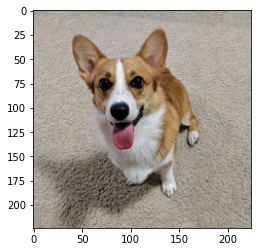

In [23]:
plt.imshow(original_img_view)

In [24]:
output = model(img_tensor)
prediction = output.max(1, keepdim=False)[1]

In [26]:
prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]
print(prediction_idx)
print(prediction_name)

263
Pembroke, Pembroke Welsh corgi


In [28]:
def fgsm_attack(img, epsilon, gradient):
    sign_gradient = gradient.sign()
    perturbed_img = img + epsilon * sign_gradient
    perturbed_img = torch.clamp(perturbed_img, 0, 1)
    return perturbed_img

In [31]:
img_tensor.requires_grad_(True)
output = model(img_tensor)
loss = F.nll_loss(output, torch.tensor([263]))

In [33]:
model.zero_grad()
loss.backward()
gradient = img_tensor.grad.data
epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)

In [34]:
output = model(perturbed_data)

In [35]:
perturbed_prediction = output.max(1, keepdim=True)[1]
perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]
print(perturbed_prediction_idx)
print(perturbed_prediction_name)

172
whippet


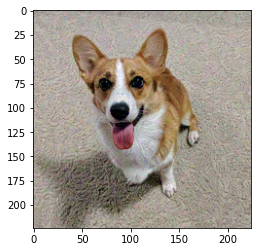

In [36]:
perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.transpose(0,2).transpose(0,1).numpy()

plt.imshow(perturbed_data_view)

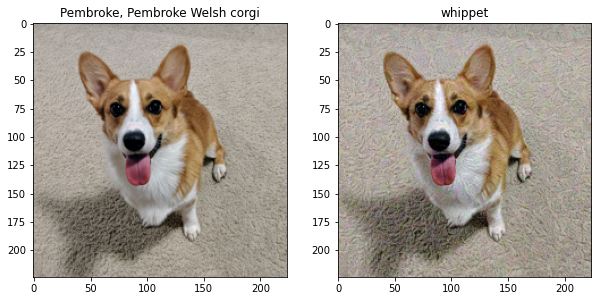

In [37]:
f, a = plt.subplots(1, 2, figsize=(10, 10))

a[0].set_title(prediction_name)
a[0].imshow(original_img_view)

a[1].set_title(perturbed_prediction_name)
a[1].imshow(perturbed_data_view)

plt.show()